# New BO Results Visualization Notebook

Interactive visualization and analysis of updated Bayesian Optimization experiments with new graph types.

## Features:
- **Multi-Graph Support**: Handles new graph types (periodic_grid, staircase_grid, etc.)
- **Automated File Discovery**: Finds latest CSV results automatically
- **JSON Conversion**: Converts CSV to structured JSON for efficient processing
- **Publication Plots**: Creates journal-quality convergence plots
- **Statistical Analysis**: Computes performance metrics across multiple seeds

## Workflow:
1. **Discover Files**: Find latest BO CSV results
2. **Convert & Cache**: Convert to JSON format for faster loading
3. **Visualize**: Create publication-ready convergence plots
4. **Analyze**: Statistical comparison across algorithms and graph types

In [3]:
import json
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from datetime import datetime
import glob
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Enhanced publication styling
mpl.rcParams.update({
    "figure.dpi": 300,
    "savefig.dpi": 300,
    "savefig.bbox": "tight",
    "font.size": 10,
    "axes.titlesize": 12,
    "axes.labelsize": 11,
    "xtick.labelsize": 9,
    "ytick.labelsize": 9,
    "legend.fontsize": 9,
    "axes.linewidth": 0.8,
    "grid.linewidth": 0.6,
    "grid.alpha": 0.3,
})

print("📊 New BO Results Visualization Notebook")
print("=" * 60)

📊 New BO Results Visualization Notebook


## 1. Automated File Discovery

Automatically finds the latest BO experiment results with support for new graph types.

In [4]:
def discover_bo_results(results_directory="results/", pattern="*bo_experiment_results*.csv"):
    """
    Discover and analyze BO result files with metadata extraction
    
    Returns:
        list: Sorted list of file info dictionaries with metadata
    """
    if not os.path.exists(results_directory):
        print(f"❌ Results directory not found: {results_directory}")
        return []
    
    search_path = os.path.join(results_directory, pattern)
    csv_files = glob.glob(search_path)
    
    if not csv_files:
        print(f"❌ No CSV files found matching: {pattern}")
        return []
    
    # Sort by modification time (newest first)
    csv_files.sort(key=os.path.getmtime, reverse=True)
    
    file_metadata = []
    
    for filepath in csv_files:
        try:
            # Quick peek at file structure
            df_peek = pd.read_csv(filepath, nrows=10)
            
            # Check for required columns
            required_cols = ['algorithm', 'iteration', 'best_value', 'regret', 'graph_type']
            missing_cols = [col for col in required_cols if col not in df_peek.columns]
            
            if missing_cols:
                print(f"⚠️  Skipping {os.path.basename(filepath)}: missing columns {missing_cols}")
                continue
            
            # Extract metadata from full file
            df_full = pd.read_csv(filepath)
            
            # Detect graph types and algorithms
            graph_types = sorted(df_full['graph_type'].unique().tolist()) if 'graph_type' in df_full.columns else ['unknown']
            algorithms = sorted(df_full['algorithm'].unique().tolist())
            n_nodes = df_full['n_nodes'].iloc[0] if 'n_nodes' in df_full.columns else 'unknown'
            bo_seeds = sorted(df_full['bo_seed'].unique().tolist()) if 'bo_seed' in df_full.columns else []
            
            file_info = {
                'filepath': filepath,
                'filename': os.path.basename(filepath),
                'size_mb': os.path.getsize(filepath) / (1024*1024),
                'modified': datetime.fromtimestamp(os.path.getmtime(filepath)),
                'total_rows': len(df_full),
                'graph_types': graph_types,
                'algorithms': algorithms,
                'n_nodes': n_nodes,
                'bo_seeds': bo_seeds,
                'num_bo_runs': len(bo_seeds),
                'max_iterations': df_full['iteration'].max() if 'iteration' in df_full.columns else 0,
                'has_multiple_graphs': len(graph_types) > 1
            }
            
            file_metadata.append(file_info)
            
        except Exception as e:
            print(f"⚠️  Error analyzing {os.path.basename(filepath)}: {e}")
    
    return file_metadata

# Configure search directory
RESULTS_DIR = "results/"
print(f"🔍 Searching for BO results in: {RESULTS_DIR}")

discovered_files = discover_bo_results(RESULTS_DIR)

if discovered_files:
    print(f"\n✅ Found {len(discovered_files)} BO result files:")
    print("-" * 80)
    
    for i, file_info in enumerate(discovered_files):
        print(f"{i+1}. {file_info['filename']}")
        print(f"   📊 Data: {file_info['total_rows']:,} rows, {file_info['size_mb']:.2f} MB")
        print(f"   🎯 Experiments: {file_info['num_bo_runs']} BO runs × {file_info['max_iterations']} iterations")
        print(f"   🏗️  Graph types: {', '.join(file_info['graph_types'])}")
        print(f"   🤖 Algorithms: {', '.join(file_info['algorithms'])}")
        print(f"   📈 Nodes: {file_info['n_nodes']:,}")
        print(f"   🕒 Modified: {file_info['modified'].strftime('%Y-%m-%d %H:%M:%S')}")
        print(f"   📁 Path: {file_info['filepath']}")
        print()
    
    # Auto-select most recent file
    SELECTED_FILE = discovered_files[0]
    print(f"🎯 Auto-selected latest file: {SELECTED_FILE['filename']}")
    
else:
    print("❌ No valid BO result files found")
    print("   Make sure you have CSV files with columns: algorithm, iteration, best_value, regret, graph_type")
    SELECTED_FILE = None

🔍 Searching for BO results in: results/

✅ Found 14 BO result files:
--------------------------------------------------------------------------------
1. bo_experiment_results_grid_multimodal_20250816_063831.csv
   📊 Data: 750 rows, 0.13 MB
   🎯 Experiments: 5 BO runs × 50 iterations
   🏗️  Graph types: grid_multimodal
   🤖 Algorithms: bfs, random_search, sparse_grf
   📈 Nodes: 1,000,000
   🕒 Modified: 2025-08-16 06:38:31
   📁 Path: results/bo_experiment_results_grid_multimodal_20250816_063831.csv

2. bo_experiment_results_grid_multimodal.csv
   📊 Data: 750 rows, 0.13 MB
   🎯 Experiments: 5 BO runs × 50 iterations
   🏗️  Graph types: grid_multimodal
   🤖 Algorithms: bfs, random_search, sparse_grf
   📈 Nodes: 1,000,000
   🕒 Modified: 2025-08-16 06:38:31
   📁 Path: results/bo_experiment_results_grid_multimodal.csv

3. bo_experiment_results_staircase_grid_20250816_043757.csv
   📊 Data: 750 rows, 0.13 MB
   🎯 Experiments: 5 BO runs × 50 iterations
   🏗️  Graph types: staircase_grid
   🤖 Alg

## 2. Enhanced CSV to JSON Conversion

Converts CSV to structured JSON with comprehensive metadata for new graph types.

In [23]:
def enhanced_csv_to_json(csv_filepath, json_filepath=None, compression=True):
    """
    Enhanced CSV to JSON converter with metadata and validation
    
    Args:
        csv_filepath: Path to input CSV file
        json_filepath: Output JSON path (auto-generated if None)
        compression: Whether to create compressed summary
    
    Returns:
        tuple: (json_filepath, metadata_dict)
    """
    if not os.path.exists(csv_filepath):
        raise FileNotFoundError(f"CSV file not found: {csv_filepath}")
    
    print(f"📄 Converting CSV to JSON: {os.path.basename(csv_filepath)}")
    
    # Load full data
    df = pd.read_csv(csv_filepath)
    
    # Generate output path if not provided
    if json_filepath is None:
        json_filepath = csv_filepath.replace('.csv', '_enhanced.json')
    
    # Extract comprehensive metadata
    metadata = {
        'conversion_timestamp': datetime.now().isoformat(),
        'source_csv': os.path.basename(csv_filepath),
        'source_size_mb': os.path.getsize(csv_filepath) / (1024*1024),
        'total_experiments': len(df),
        
        # Data structure info
        'columns': list(df.columns),
        'data_types': {col: str(dtype) for col, dtype in df.dtypes.items()},
        
        # Experimental design
        'graph_types': sorted(df['graph_type'].unique().tolist()) if 'graph_type' in df.columns else [],
        'algorithms': sorted(df['algorithm'].unique().tolist()) if 'algorithm' in df.columns else [],
        'bo_seeds': sorted(df['bo_seed'].unique().tolist()) if 'bo_seed' in df.columns else [],
        'num_bo_runs': len(df['bo_seed'].unique()) if 'bo_seed' in df.columns else 0,
        
        # Scale and scope
        'n_nodes': int(df['n_nodes'].iloc[0]) if 'n_nodes' in df.columns and len(df) > 0 else None,
        'max_iterations': int(df['iteration'].max()) if 'iteration' in df.columns else None,
        'min_iterations': int(df['iteration'].min()) if 'iteration' in df.columns else None,
        'batch_size': int(df['batch_size'].iloc[0]) if 'batch_size' in df.columns and len(df) > 0 else None,
        
        # Performance summary
        'ground_truth_best': float(df['ground_truth_best'].iloc[0]) if 'ground_truth_best' in df.columns and len(df) > 0 else None,
        'final_regrets': {},  # Will be computed below
        'convergence_stats': {}  # Will be computed below
    }
    
    # Compute performance statistics per algorithm and graph type
    if len(df) > 0 and 'iteration' in df.columns:
        final_iteration = df['iteration'].max()
        final_results = df[df['iteration'] == final_iteration]
        
        # Group by algorithm and graph_type if available
        if 'graph_type' in df.columns:
            for (graph_type, algorithm), group in final_results.groupby(['graph_type', 'algorithm']):
                key = f"{graph_type}_{algorithm}"
                metadata['final_regrets'][key] = {
                    'mean': float(group['regret'].mean()),
                    'std': float(group['regret'].std()),
                    'min': float(group['regret'].min()),
                    'max': float(group['regret'].max()),
                    'runs': len(group)
                }
        else:
            for algorithm, group in final_results.groupby('algorithm'):
                metadata['final_regrets'][algorithm] = {
                    'mean': float(group['regret'].mean()),
                    'std': float(group['regret'].std()),
                    'min': float(group['regret'].min()),
                    'max': float(group['regret'].max()),
                    'runs': len(group)
                }
    
    # Create structured JSON data
    json_data = {
        'metadata': metadata,
        'results': df.to_dict('records') if not compression else None,
        'summary_results': None  # Will add compressed version if requested
    }
    
    # Add compressed summary if requested
    if compression and len(df) > 0:
        # Create iteration-level summary (mean/std across seeds)
        if 'graph_type' in df.columns:
            summary_groups = ['graph_type', 'algorithm', 'iteration']
        else:
            summary_groups = ['algorithm', 'iteration']
        
        summary_df = df.groupby(summary_groups).agg({
            'best_value': ['mean', 'std', 'count'],
            'regret': ['mean', 'std', 'min', 'max'],
            'dataset_size': ['mean', 'std'],
            'ground_truth_best': 'first'
        }).round(6)
        
        # Flatten column names
        summary_df.columns = ['_'.join(col).strip() for col in summary_df.columns]
        summary_df = summary_df.reset_index()
        
        json_data['summary_results'] = summary_df.to_dict('records')
        json_data['results'] = None  # Save space by not including full results
        
        metadata['compression_applied'] = True
        metadata['summary_rows'] = len(summary_df)
        metadata['compression_ratio'] = f"{len(df) / len(summary_df):.1f}x" if len(summary_df) > 0 else "N/A"
    
    # Save JSON file
    with open(json_filepath, 'w') as f:
        json.dump(json_data, f, indent=2)
    
    print(f"✅ Enhanced JSON saved: {os.path.basename(json_filepath)}")
    print(f"   📊 Experiments: {metadata['total_experiments']:,}")
    print(f"   🏗️  Graph types: {metadata['graph_types']}")
    print(f"   🤖 Algorithms: {metadata['algorithms']}")
    print(f"   🎯 BO runs: {metadata['num_bo_runs']}")
    print(f"   📈 Iterations: {metadata['min_iterations']} - {metadata['max_iterations']}")
    if compression:
        print(f"   🗜️  Compression: {metadata.get('compression_ratio', 'N/A')}")
    
    return json_filepath, metadata

# Convert selected file to JSON
if SELECTED_FILE:
    try:
        json_path, conversion_metadata = enhanced_csv_to_json(
            SELECTED_FILE['filepath'], 
            compression=True  # Use compression for faster loading
        )
        
        print(f"\n🎉 Conversion completed!")
        CONVERTED_JSON_PATH = json_path
        
    except Exception as e:
        print(f"❌ Conversion failed: {e}")
        CONVERTED_JSON_PATH = None
else:
    print("⚠️ No file selected for conversion")
    CONVERTED_JSON_PATH = None

📄 Converting CSV to JSON: bo_experiment_results_circle_20250815_233315.csv
✅ Enhanced JSON saved: bo_experiment_results_circle_20250815_233315_enhanced.json
   📊 Experiments: 750
   🏗️  Graph types: ['circle']
   🤖 Algorithms: ['bfs', 'random_search', 'sparse_grf']
   🎯 BO runs: 5
   📈 Iterations: 1 - 50
   🗜️  Compression: 5.0x

🎉 Conversion completed!


## 3. Enhanced Data Loading & Visualization

Load JSON data and create publication-quality plots with support for multiple graph types.

📊 Loading enhanced JSON: bo_experiment_results_circle_20250815_233315_enhanced.json
   📈 Loaded compressed summary: 150 summary rows
   🏗️  Graph types: ['circle']
   🤖 Algorithms: ['bfs', 'random_search', 'sparse_grf']
   🎯 BO runs: 5

📈 Creating enhanced convergence plots...
📈 Creating convergence plots...
   Graph types: ['circle']
   Algorithms: ['bfs', 'random_search', 'sparse_grf']
   Data format: summary


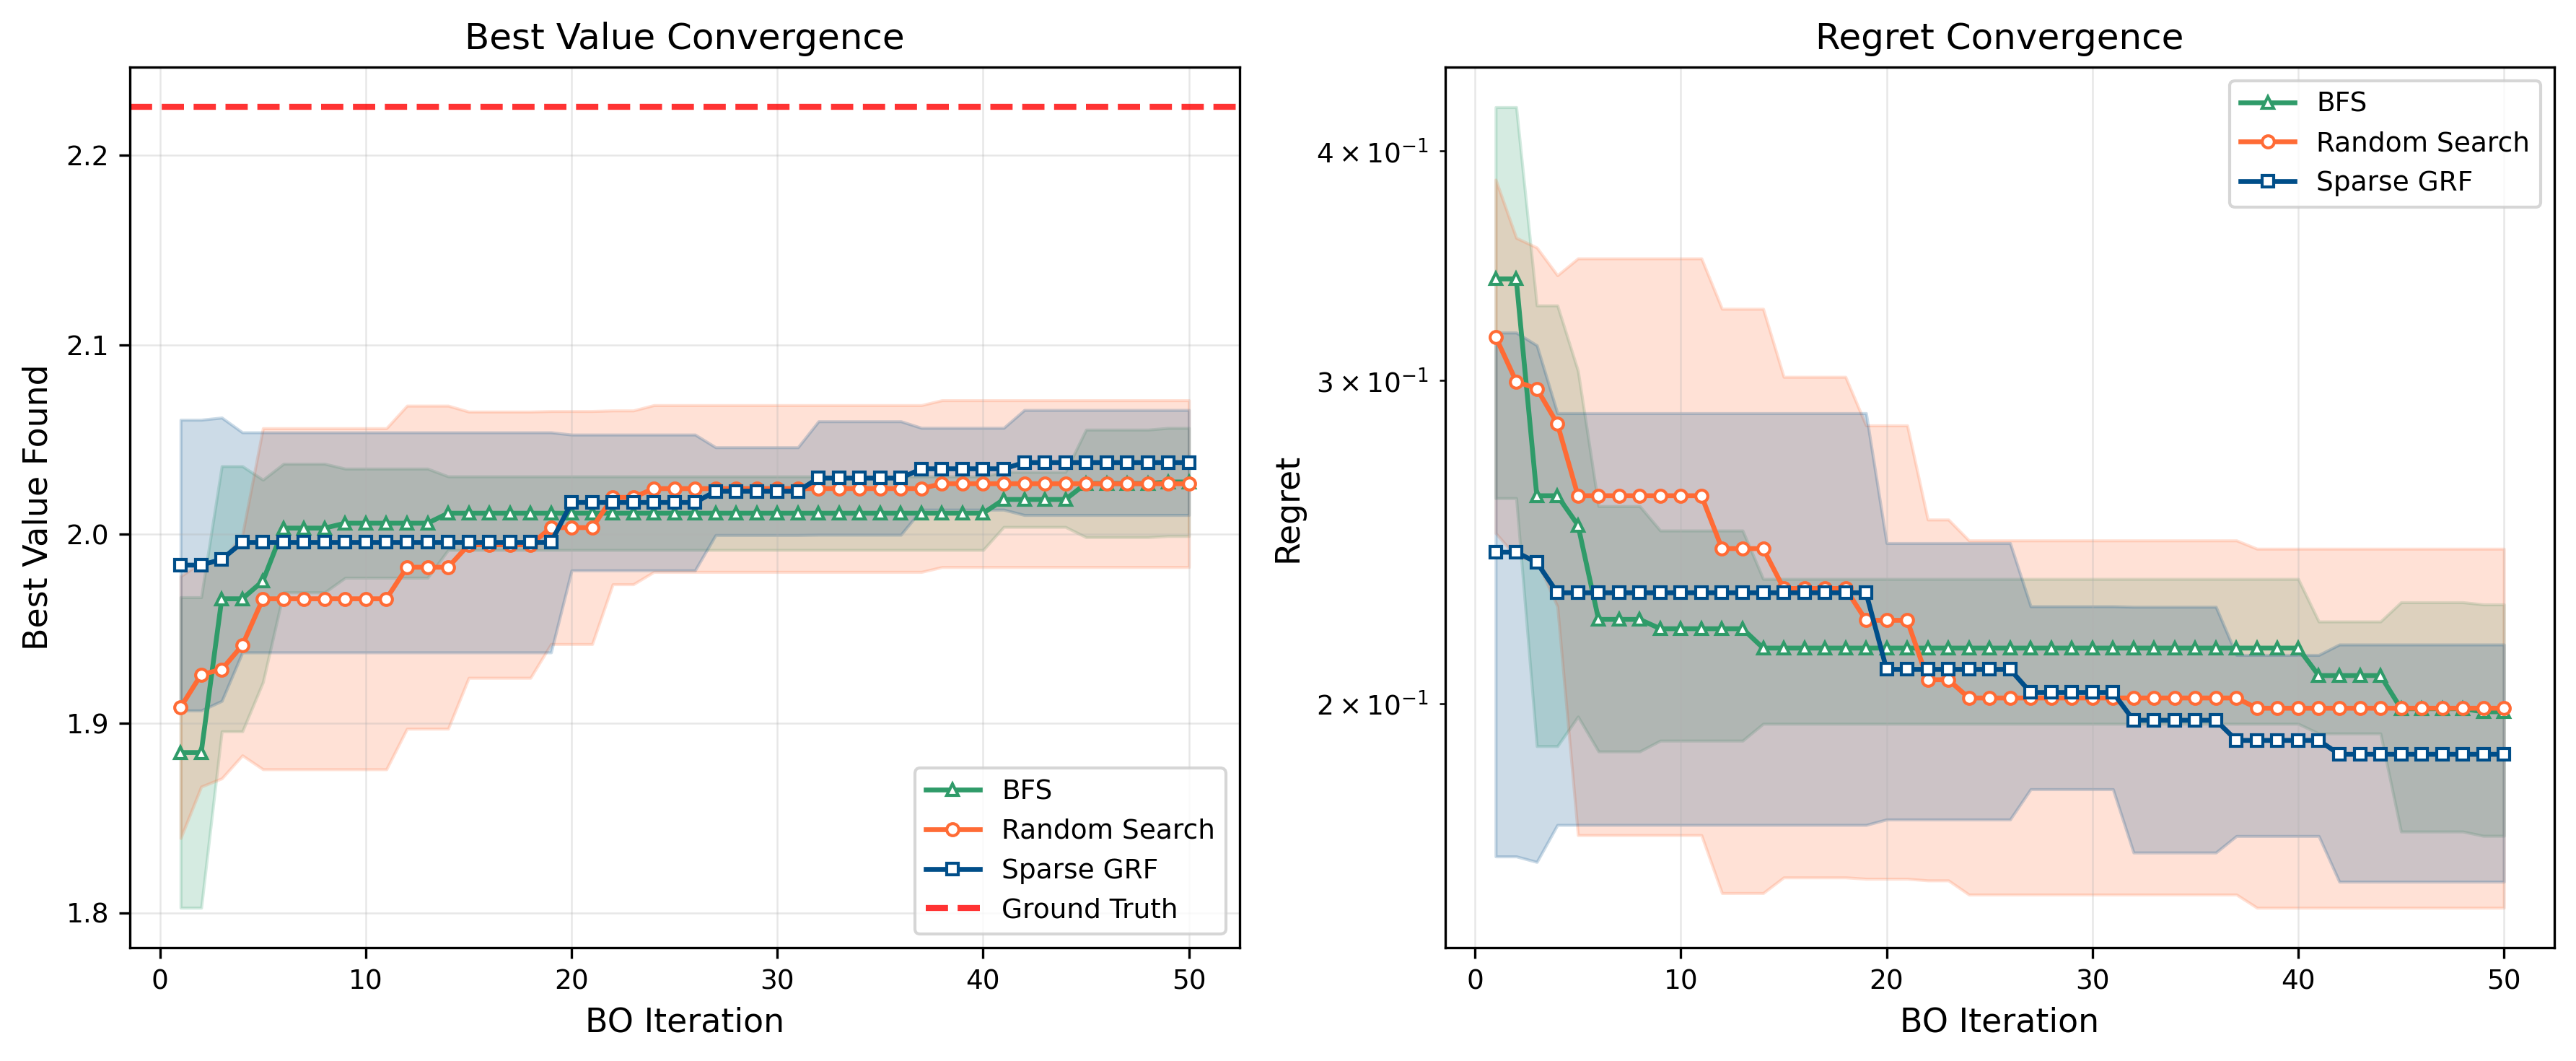

In [24]:
def load_enhanced_json(json_filepath):
    """Load enhanced JSON results with validation"""
    if not os.path.exists(json_filepath):
        raise FileNotFoundError(f"JSON file not found: {json_filepath}")
    
    print(f"📊 Loading enhanced JSON: {os.path.basename(json_filepath)}")
    
    with open(json_filepath, 'r') as f:
        data = json.load(f)
    
    metadata = data['metadata']
    
    # Load appropriate results format
    if data.get('summary_results') is not None:
        # Load compressed summary
        df = pd.DataFrame(data['summary_results'])
        print(f"   📈 Loaded compressed summary: {len(df)} summary rows")
        result_type = "summary"
    elif data.get('results') is not None:
        # Load full results
        df = pd.DataFrame(data['results'])
        print(f"   📈 Loaded full results: {len(df)} experiment rows")
        result_type = "full"
    else:
        raise ValueError("No results data found in JSON file")
    
    print(f"   🏗️  Graph types: {metadata.get('graph_types', [])}")
    print(f"   🤖 Algorithms: {metadata.get('algorithms', [])}")
    print(f"   🎯 BO runs: {metadata.get('num_bo_runs', 0)}")
    
    return df, metadata, result_type

def create_multi_graph_convergence_plots(df, metadata, result_type="summary", figsize=(16, 10)):
    """
    Create publication-quality convergence plots supporting multiple graph types
    """
    
    # Determine if we have multiple graph types
    has_graph_types = 'graph_type' in df.columns and len(df['graph_type'].unique()) > 1
    graph_types = sorted(df['graph_type'].unique()) if 'graph_type' in df.columns else ['single']
    algorithms = sorted(df['algorithm'].unique()) if 'algorithm' in df.columns else []
    
    print(f"📈 Creating convergence plots...")
    print(f"   Graph types: {graph_types}")
    print(f"   Algorithms: {algorithms}")
    print(f"   Data format: {result_type}")
    
    # Color scheme
    colors = {
        'random_search': '#FF6B35',     # Orange
        'sparse_grf': '#004E89',        # Blue
        'bfs': '#2F9B69',               # Green
        'dfs': '#9B2F68',               # Purple
        'thompson_sampling': '#8A2BE2'  # Violet
    }
    
    # Marker scheme
    markers = {
        'random_search': 'o',      # Circle
        'sparse_grf': 's',         # Square
        'bfs': '^',                # Triangle up
        'dfs': 'v',                # Triangle down
        'thompson_sampling': 'D'   # Diamond
    }
    
    # Legend names
    legend_names = {
        'random_search': 'Random Search',
        'sparse_grf': r'Sparse GRF',
        'bfs': 'BFS',
        'dfs': 'DFS',
        'thompson_sampling': 'Thompson Sampling'
    }
    
    # Determine subplot layout
    if has_graph_types:
        n_graphs = len(graph_types)
        n_cols = min(3, n_graphs)  # Max 3 columns
        n_rows = (n_graphs + n_cols - 1) // n_cols
        figsize = (5 * n_cols, 4 * n_rows)
    else:
        n_rows, n_cols = 1, 2  # Single row: best_value, regret
        figsize = (12, 5)
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=figsize)
    if n_rows == 1 and n_cols == 1:
        axes = [axes]
    elif n_rows == 1 or n_cols == 1:
        axes = axes.flatten()
    else:
        axes = axes.flatten()
    
    # Plot for each graph type (or single plot if no graph types)
    for i, graph_type in enumerate(graph_types):
        if has_graph_types:
            graph_data = df[df['graph_type'] == graph_type]
            ax = axes[i] if len(axes) > i else axes[0]
            title = f'Regret Convergence - {graph_type.replace("_", " ").title()}'
        else:
            graph_data = df
            # Create two subplots for single graph type
            if len(axes) >= 2:
                ax_best = axes[0]
                ax_regret = axes[1]
            else:
                ax_best = ax_regret = axes[0]
            
        # Determine if we have summary or full data
        if result_type == "summary":
            # Summary data: use mean and std columns
            regret_col = 'regret_mean'
            regret_std_col = 'regret_std'
            best_value_col = 'best_value_mean'
            best_value_std_col = 'best_value_std'
        else:
            # Full data: compute mean and std on the fly
            regret_col = 'regret'
            best_value_col = 'best_value'
            graph_data = graph_data.groupby(['algorithm', 'iteration']).agg({
                'regret': ['mean', 'std'],
                'best_value': ['mean', 'std']
            }).reset_index()
            graph_data.columns = ['algorithm', 'iteration', 'regret_mean', 'regret_std', 'best_value_mean', 'best_value_std']
            regret_std_col = 'regret_std'
            best_value_std_col = 'best_value_std'
        
        # Plot each algorithm
        for algorithm in algorithms:
            algo_data = graph_data[graph_data['algorithm'] == algorithm]
            
            if len(algo_data) == 0:
                continue
            
            color = colors.get(algorithm, '#000000')
            marker = markers.get(algorithm, 'o')
            label = legend_names.get(algorithm, algorithm.replace('_', ' ').title())
            
            if has_graph_types:
                # Single regret plot per graph type
                if regret_col in algo_data.columns:
                    iterations = algo_data['iteration']
                    regret_mean = algo_data[regret_col]
                    regret_std = algo_data[regret_std_col] if regret_std_col in algo_data.columns else None
                    
                    ax.plot(iterations, regret_mean, marker=marker, color=color, 
                           label=label, linewidth=1.6, markersize=4, markerfacecolor='white', 
                           markeredgewidth=1.0)
                    
                    if regret_std is not None and not regret_std.isna().all():
                        ax.fill_between(iterations, regret_mean - regret_std, regret_mean + regret_std, 
                                       color=color, alpha=0.2)
                
                ax.set_xlabel('BO Iteration')
                ax.set_ylabel('Regret')
                ax.set_title(title)
                ax.set_yscale('log')
                ax.grid(True, alpha=0.3)
                ax.legend()
                
            else:
                # Two plots: best value and regret
                iterations = algo_data['iteration']
                
                # Best value plot
                if best_value_col in algo_data.columns:
                    best_mean = algo_data[best_value_col]
                    best_std = algo_data[best_value_std_col] if best_value_std_col in algo_data.columns else None
                    
                    ax_best.plot(iterations, best_mean, marker=marker, color=color, 
                               label=label, linewidth=1.6, markersize=4, markerfacecolor='white', 
                               markeredgewidth=1.0)
                    
                    if best_std is not None and not best_std.isna().all():
                        ax_best.fill_between(iterations, best_mean - best_std, best_mean + best_std, 
                                           color=color, alpha=0.2)
                
                # Regret plot
                if regret_col in algo_data.columns:
                    regret_mean = algo_data[regret_col]
                    regret_std = algo_data[regret_std_col] if regret_std_col in algo_data.columns else None
                    
                    ax_regret.plot(iterations, regret_mean, marker=marker, color=color, 
                                 label=label, linewidth=1.6, markersize=4, markerfacecolor='white', 
                                 markeredgewidth=1.0)
                    
                    if regret_std is not None and not regret_std.isna().all():
                        ax_regret.fill_between(iterations, regret_mean - regret_std, regret_mean + regret_std, 
                                             color=color, alpha=0.2)
        
        # Configure single graph type axes
        if not has_graph_types:
            # Ground truth line for best value plot
            ground_truth = metadata.get('ground_truth_best')
            if ground_truth is not None:
                ax_best.axhline(y=ground_truth, color='red', linestyle='--', 
                              label='Ground Truth', linewidth=2, alpha=0.8)
            
            ax_best.set_xlabel('BO Iteration')
            ax_best.set_ylabel('Best Value Found')
            ax_best.set_title('Best Value Convergence')
            ax_best.legend()
            ax_best.grid(True, alpha=0.3)
            
            ax_regret.set_xlabel('BO Iteration')
            ax_regret.set_ylabel('Regret')
            ax_regret.set_title('Regret Convergence')
            ax_regret.set_yscale('log')
            ax_regret.legend()
            ax_regret.grid(True, alpha=0.3)
    
    # Remove empty subplots
    if has_graph_types and len(graph_types) < len(axes):
        for j in range(len(graph_types), len(axes)):
            fig.delaxes(axes[j])
    
    plt.tight_layout()
    plt.show()
    
    return fig

# Load data and create visualizations
if CONVERTED_JSON_PATH and os.path.exists(CONVERTED_JSON_PATH):
    try:
        df, metadata, result_type = load_enhanced_json(CONVERTED_JSON_PATH)
        
        print(f"\n📈 Creating enhanced convergence plots...")
        convergence_fig = create_multi_graph_convergence_plots(df, metadata, result_type)
        
    except Exception as e:
        print(f"❌ Visualization failed: {e}")
        import traceback
        traceback.print_exc()
        
else:
    print("❌ No JSON file available for visualization")
    print("   Please run the conversion step first")

## 5. Export & Save Functions

Save processed results and publication-ready figures.

In [18]:
def save_processed_results(df, metadata, performance_df=None, output_dir="processed_results/"):
    """
    Save processed results and figures for publication
    """
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    os.makedirs(output_dir, exist_ok=True)
    
    # Save processed data
    processed_json = os.path.join(output_dir, f"processed_bo_results_{timestamp}.json")
    
    save_data = {
        'metadata': metadata,
        'processed_timestamp': timestamp,
        'convergence_data': df.to_dict('records'),
        'performance_summary': performance_df.to_dict('records') if performance_df is not None else None
    }
    
    with open(processed_json, 'w') as f:
        json.dump(save_data, f, indent=2)
    
    print(f"💾 Processed results saved:")
    print(f"   📄 JSON: {processed_json}")
    
    # Save performance summary as CSV
    if performance_df is not None:
        perf_csv = os.path.join(output_dir, f"performance_summary_{timestamp}.csv")
        performance_df.to_csv(perf_csv, index=False)
        print(f"   📊 Performance CSV: {perf_csv}")
    
    return {
        'processed_json': processed_json,
        'performance_csv': perf_csv if performance_df is not None else None,
        'timestamp': timestamp
    }

def save_publication_figure(fig, filename_base, output_dir="figures/", formats=['png', 'pdf']):
    """
    Save figures in publication formats
    """
    os.makedirs(output_dir, exist_ok=True)
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    
    saved_files = []
    
    for fmt in formats:
        filepath = os.path.join(output_dir, f"{filename_base}_{timestamp}.{fmt}")
        fig.savefig(filepath, format=fmt, dpi=300, bbox_inches='tight', facecolor='white')
        saved_files.append(filepath)
        print(f"🖼️  Saved {fmt.upper()}: {filepath}")
    
    return saved_files

# Save results if available
if 'df' in locals() and 'metadata' in locals():
    try:
        # Save processed data
        saved_results = save_processed_results(
            df, metadata, 
            performance_df if 'performance_df' in locals() else None
        )
        
        # Save convergence figure if available
        if 'convergence_fig' in locals():
            saved_figures = save_publication_figure(
                convergence_fig, 
                "bo_convergence_comparison",
                formats=['png', 'pdf', 'svg']
            )
        
        print(f"\n✅ All results and figures saved successfully!")
        
    except Exception as e:
        print(f"❌ Error saving results: {e}")
        
else:
    print("⚠️ No processed data available to save")

💾 Processed results saved:
   📄 JSON: processed_results/processed_bo_results_20250816_091549.json
   📊 Performance CSV: processed_results/performance_summary_20250816_091549.csv
🖼️  Saved PNG: figures/bo_convergence_comparison_20250816_091550.png
🖼️  Saved PDF: figures/bo_convergence_comparison_20250816_091550.pdf
🖼️  Saved SVG: figures/bo_convergence_comparison_20250816_091550.svg

✅ All results and figures saved successfully!


## Quick Usage Instructions

**To analyze your latest BO results:**

1. **Auto-discovery**: The notebook automatically finds your latest CSV files
2. **Conversion**: Converts to JSON format for efficient processing
3. **Visualization**: Creates publication-quality convergence plots
4. **Analysis**: Computes statistical performance metrics
5. **Export**: Saves processed data and figures

**For manual file selection:**
```python
# Override auto-selection
SELECTED_FILE = discovered_files[1]  # Choose different file
# Then re-run conversion and visualization cells
```

**For custom visualization:**
```python
# Load specific JSON file
custom_df, custom_metadata, _ = load_enhanced_json("path/to/your/file.json")
custom_fig = create_multi_graph_convergence_plots(custom_df, custom_metadata)
```

The notebook handles all new graph types (periodic_grid, staircase_grid, etc.) automatically!

In [22]:
SELECTED_FILE = discovered_files[8]
print(SELECTED_FILE)

{'filepath': 'results/bo_experiment_results_circle_20250815_233315.csv', 'filename': 'bo_experiment_results_circle_20250815_233315.csv', 'size_mb': 0.12328243255615234, 'modified': datetime.datetime(2025, 8, 15, 23, 33, 16, 58509), 'total_rows': 750, 'graph_types': ['circle'], 'algorithms': ['bfs', 'random_search', 'sparse_grf'], 'n_nodes': 1000000, 'bo_seeds': [100, 110, 120, 130, 140], 'num_bo_runs': 5, 'max_iterations': 50, 'has_multiple_graphs': False}


In [ ]:
multimodel grid
periodic
grid, old result
circle